# 프로젝트 - Movielens 영화 추천 실습
## <목차>
#### STEP1. 데이터 준비와 전처리
    (1) 데이터 준비
    (2) 데이터 탐색
    (3) 사용자 초기 정보 세팅
#### STEP2. 데이터 전처리
#### STEP3.CSR matrix
#### STEP4. 모델 훈련
#### STEP5. 선호도 파악!
#### STEP6. 비슷한 영화 추천
#### STEP7. 결과 분석 및 정리
#### 🤔회고🤔
#### Reference

***

# STEP1. 데이터 준비와 전처리
## (1) 데이터 준비
- 사용자 데이터 가져오기
- 영화 데이터 가져오기

In [1]:
import pandas as pd
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## (2) 데이터 탐색
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)
- 사용자 데이터에서 각 유저별로 시청한 movie 개수 파악하기
- 3점 이하의 평점은 제외하기
- #명시적/암묵적 평가 : 평가 기준에 대해서 어떻게 설정할지 고민이 필요함

In [3]:
ratings['movie_id'].nunique()

3706

In [4]:
ratings['user_id'].nunique()

6040

In [5]:
movie_count = ratings.groupby('movie_id')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
2028    2653
589     2649
2571    2590
1270    2583
593     2578
1580    2538
1198    2514
608     2513
2762    2459
110     2443
2396    2369
1197    2318
527     2304
1617    2288
1265    2278
1097    2269
2628    2250
2997    2241
318     2227
858     2223
356     2194
2716    2181
296     2171
1240    2098
1       2077
Name: user_id, dtype: int64

In [6]:
ratings.groupby('user_id').count()

,movie_id,ratings,timestamp
user_id,,,
1,53,53,53
2,129,129,129
3,51,51,51
4,21,21,21
5,198,198,198
...,...,...,...
6036,888,888,888
6037,202,202,202
6038,20,20,20


In [7]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [8]:
# 필요없는 데이터 열 제거
group = ratings.drop(['ratings', 'timestamp'], axis=1)

# 컬럼명 변경
group = group.rename({'movie_id':'Num_movies'}, axis='columns')

group_1 = group.groupby('user_id').count()
group_1

,Num_movies
user_id,
1,53
2,116
3,46
4,19
5,143
...,...
6036,708
6037,189
6038,18


In [9]:
group.groupby('user_id').count().describe()

,Num_movies
count,6039.000000
mean,138.512668
std,156.241599
min,1.000000
25%,38.000000
50%,81.000000
75%,177.000000
max,1968.000000


In [10]:
group_1.loc[group_1['Num_movies'] <= 10]

,Num_movies
user_id,
941,10
1102,9
4056,9
4349,7
4365,9
4486,1
4636,9


<BarContainer object of 6039 artists>

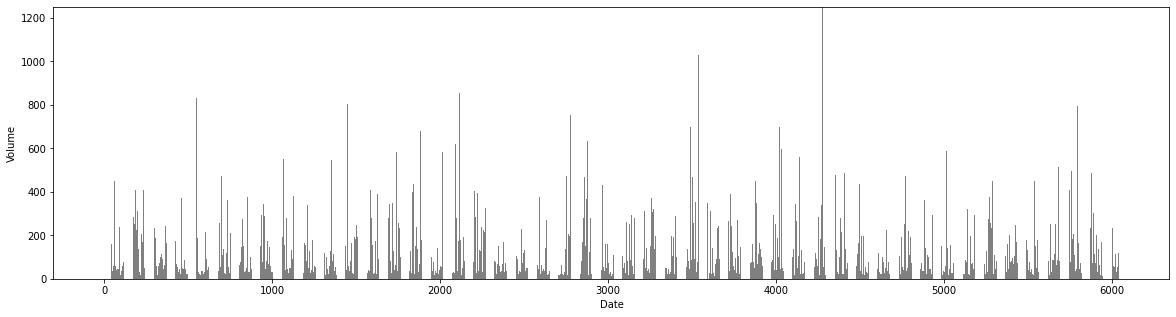

In [11]:
import matplotlib.pyplot as plt

xs=group_1.index.to_list()
ys=group_1['Num_movies'].to_list()

plt.figure(figsize=(20, 5))
plt.xlabel('Date')
plt.ylabel('Volume')
plt.ylim(0, 1250)

plt.bar(xs, ys, width=0.6, color='grey')

<AxesSubplot:xlabel='user_id'>

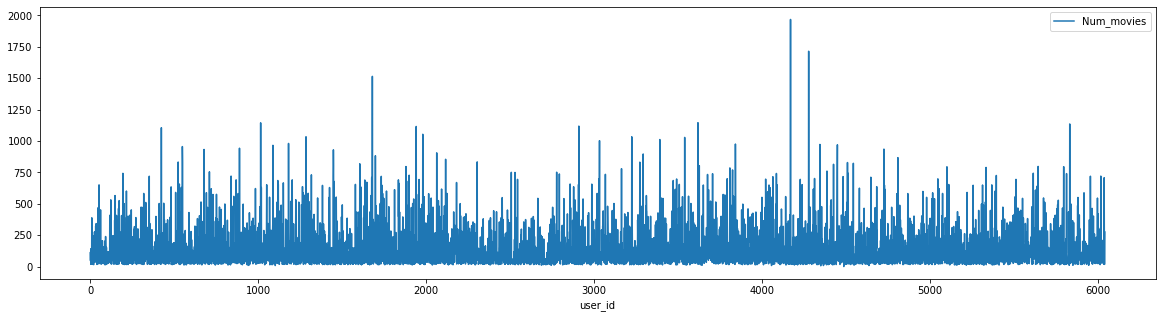

In [12]:
%matplotlib inline

group_1.plot(figsize=(20,5))

In [13]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [14]:
movies.groupby('genre').count()

,movie_id,title
genre,,
Action,65,65
Action|Adventure,25,25
Action|Adventure|Animation,1,1
Action|Adventure|Animation|Children's|Fantasy,1,1
Action|Adventure|Animation|Horror|Sci-Fi,1,1
...,...,...
Sci-Fi|Thriller|War,1,1
Sci-Fi|War,1,1
Thriller,101,101


In [15]:
# 검색을 쉽게 하기 위해 영화 제목을 소문자로 변경
movies['title'] = movies['title'].str.lower() # 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
movies.head(10)

,movie_id,title,genre
0,1,toy story (1995),Animation|Children's|Comedy
1,2,jumanji (1995),Adventure|Children's|Fantasy
2,3,grumpier old men (1995),Comedy|Romance
3,4,waiting to exhale (1995),Comedy|Drama
4,5,father of the bride part ii (1995),Comedy
5,6,heat (1995),Action|Crime|Thriller
6,7,sabrina (1995),Comedy|Romance
7,8,tom and huck (1995),Adventure|Children's
8,9,sudden death (1995),Action
9,10,goldeneye (1995),Action|Adventure|Thriller


In [16]:
type(movies)

pandas.core.frame.DataFrame

### <merge로 df 합치기>

In [17]:
merge_movies = pd.merge(ratings, movies, how='left', on='movie_id')
#merge_movies.sort_values('user_id')
merge_movies.loc[merge_movies['user_id'] == 1]

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,one flew over the cuckoo's nest (1975),Drama
1,1,661,3,978302109,james and the giant peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,my fair lady (1964),Musical|Romance
3,1,3408,4,978300275,erin brockovich (2000),Drama
4,1,2355,5,978824291,"bug's life, a (1998)",Animation|Children's|Comedy
5,1,1197,3,978302268,"princess bride, the (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,978302039,ben-hur (1959),Action|Adventure|Drama
7,1,2804,5,978300719,"christmas story, a (1983)",Comedy|Drama
8,1,594,4,978302268,snow white and the seven dwarfs (1937),Animation|Children's|Musical
9,1,919,4,978301368,"wizard of oz, the (1939)",Adventure|Children's|Drama|Musical


In [18]:
ratings.loc[ratings['user_id'] == 1]

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [19]:
print(ratings.shape[0])
print(merge_movies.shape[0])

836478
836478


In [20]:
# 필요없는 데이터 열 제거
merge_movies_1 = merge_movies.drop(['timestamp', 'genre'], axis=1)

# 컬럼명 변경하기
merge_movies_1.rename(columns={'ratings':'counts'}, inplace=True)

merge_movies_1.tail()

,user_id,movie_id,counts,title
836473,6040,1090,3,platoon (1986)
836474,6040,1094,5,"crying game, the (1992)"
836475,6040,562,5,welcome to the dollhouse (1995)
836476,6040,1096,4,sophie's choice (1982)
836477,6040,1097,4,e.t. the extra-terrestrial (1982)


In [21]:
merge_movies_1['user_id'].nunique()

6039

## (3) 사용자 초기 정보 세팅
- 내가 좋아하는 영화 지정을 위해 전체 영화 리스트 뽑아보기
- 영화들이 너무 예전 영화들이라 그냥 랜덤으로 5개 뽑고자 한다..
- 모델 검증을 위한 사용자 초기 정보 세팅
- 마지막 user_id는 6040임을 확인

### <장르 구별하지 않고 랜덤 추출>

In [21]:
title_list = movies['title'].values.tolist()
print(title_list)

['toy story (1995)', 'jumanji (1995)', 'grumpier old men (1995)', 'waiting to exhale (1995)', 'father of the bride part ii (1995)', 'heat (1995)', 'sabrina (1995)', 'tom and huck (1995)', 'sudden death (1995)', 'goldeneye (1995)', 'american president, the (1995)', 'dracula: dead and loving it (1995)', 'balto (1995)', 'nixon (1995)', 'cutthroat island (1995)', 'casino (1995)', 'sense and sensibility (1995)', 'four rooms (1995)', 'ace ventura: when nature calls (1995)', 'money train (1995)', 'get shorty (1995)', 'copycat (1995)', 'assassins (1995)', 'powder (1995)', 'leaving las vegas (1995)', 'othello (1995)', 'now and then (1995)', 'persuasion (1995)', 'city of lost children, the (1995)', 'shanghai triad (yao a yao yao dao waipo qiao) (1995)', 'dangerous minds (1995)', 'twelve monkeys (1995)', 'wings of courage (1995)', 'babe (1995)', 'carrington (1995)', 'dead man walking (1995)', 'across the sea of time (1995)', 'it takes two (1995)', 'clueless (1995)', 'cry, the beloved country (199

In [18]:
import random
random_title = random.sample(title_list, 5)
random_title

['still breathing (1997)',
 'i love trouble (1994)',
 'golden voyage of sinbad, the (1974)',
 'rain (1932)',
 'children of the corn ii: the final sacrifice (1993)']

In [33]:
#random_title_5 = [''still breathing (1997)','i love trouble (1994)','golden voyage of sinbad, the (1974)','rain (1932)','children of the corn ii: the final sacrifice (1993)']
movies[movies['title'].isin(random_title)]

,movie_id,title,genre
356,360,i love trouble (1994),Action|Comedy
1805,1874,still breathing (1997),Comedy|Romance
2446,2515,children of the corn ii: the final sacrifice (...,Horror
2835,2904,rain (1932),Drama
3702,3771,"golden voyage of sinbad, the (1974)",Action|Adventure


In [24]:
print(movies.loc[(movies['movie_id'] ==360)])
print(movies.loc[(movies['movie_id'] ==1874)])
print(movies.loc[(movies['movie_id'] ==2515)])
print(movies.loc[(movies['movie_id'] ==2904)])
print(movies.loc[(movies['movie_id'] ==3771)])


     movie_id                  title          genre
356       360  i love trouble (1994)  Action|Comedy
      movie_id                   title           genre
1805      1874  still breathing (1997)  Comedy|Romance
      movie_id                                              title   genre
2446      2515  children of the corn ii: the final sacrifice (...  Horror
      movie_id        title  genre
2835      2904  rain (1932)  Drama
      movie_id                                title             genre
3702      3771  golden voyage of sinbad, the (1974)  Action|Adventure


### <장르를 sf로 맞추고 랜덤 추출>

In [58]:
import random
genre_sci = movies[movies['genre'].str.contains('Sci')]
genre_list = genre_sci['title'].values.tolist()
random_title_2 = random.sample(genre_list, 5)
movies[movies['title'].isin(random_title_2)]

,movie_id,title,genre
65,66,lawnmower man 2: beyond cyberspace (1996),Sci-Fi|Thriller
257,260,star wars: episode iv - a new hope (1977),Action|Adventure|Fantasy|Sci-Fi
1550,1591,spawn (1997),Action|Adventure|Sci-Fi|Thriller
2832,2901,phantasm (1979),Horror|Sci-Fi
3631,3700,"brother from another planet, the (1984)",Drama|Sci-Fi


### <df에 내 정보 세팅하기>

In [22]:
my_favorite_id = [360, 1874, 2515, 2904, 3771]
my_favorite_title = ['i love trouble (1994)', 'still breathing (1997)', 'children of the corn ii: the final sacrifice (1993)', 'rain (1932)','golden voyage of sinbad, the (1974)']
my_favorite_count	 = [5,4,3,5,5]

my_movielist = pd.DataFrame({'user_id': ['gabi']*5, 'movie_id': my_favorite_id, 'counts': my_favorite_count, 'title': my_favorite_title})
my_movielist

,user_id,movie_id,counts,title
0,gabi,360,5,i love trouble (1994)
1,gabi,1874,4,still breathing (1997)
2,gabi,2515,3,children of the corn ii: the final sacrifice (...
3,gabi,2904,5,rain (1932)
4,gabi,3771,5,"golden voyage of sinbad, the (1974)"


In [23]:
merge_movies_1 = merge_movies_1.append(my_movielist, ignore_index=True)
merge_movies_1.tail(10)

,user_id,movie_id,counts,title
836473,6040,1090,3,platoon (1986)
836474,6040,1094,5,"crying game, the (1992)"
836475,6040,562,5,welcome to the dollhouse (1995)
836476,6040,1096,4,sophie's choice (1982)
836477,6040,1097,4,e.t. the extra-terrestrial (1982)
836478,gabi,360,5,i love trouble (1994)
836479,gabi,1874,4,still breathing (1997)
836480,gabi,2515,3,children of the corn ii: the final sacrifice (...
836481,gabi,2904,5,rain (1932)
836482,gabi,3771,5,"golden voyage of sinbad, the (1974)"


In [22]:
my_favorite_id_2 = [66, 260, 1591, 2901, 3700]
my_favorite_title_2 = ['lawnmower man 2: beyond cyberspace (1996)', 'star wars: episode iv - a new hope (1977)', 'spawn (1997)', 'phantasm (1979)','brother from another planet, the (1984)']
my_favorite_count_2	 = [5,4,3,5,5]

my_movielist_2 = pd.DataFrame({'user_id': ['gabi']*5, 'movie_id': my_favorite_id_2, 'counts': my_favorite_count_2, 'title': my_favorite_title_2})
my_movielist_2

,user_id,movie_id,counts,title
0,gabi,66,5,lawnmower man 2: beyond cyberspace (1996)
1,gabi,260,4,star wars: episode iv - a new hope (1977)
2,gabi,1591,3,spawn (1997)
3,gabi,2901,5,phantasm (1979)
4,gabi,3700,5,"brother from another planet, the (1984)"


In [23]:
merge_movies_3 = merge_movies_1.append(my_movielist_2, ignore_index=True)
merge_movies_3.tail(10)

,user_id,movie_id,counts,title
836473,6040,1090,3,platoon (1986)
836474,6040,1094,5,"crying game, the (1992)"
836475,6040,562,5,welcome to the dollhouse (1995)
836476,6040,1096,4,sophie's choice (1982)
836477,6040,1097,4,e.t. the extra-terrestrial (1982)
836478,gabi,66,5,lawnmower man 2: beyond cyberspace (1996)
836479,gabi,260,4,star wars: episode iv - a new hope (1977)
836480,gabi,1591,3,spawn (1997)
836481,gabi,2901,5,phantasm (1979)
836482,gabi,3700,5,"brother from another planet, the (1984)"


## (4) 평점 적은 user_id 제거

In [24]:
group_1.loc[group_1['Num_movies'] <= 10]

,Num_movies
user_id,
941,10
1102,9
4056,9
4349,7
4365,9
4486,1
4636,9


In [25]:
# 3점 이상만 남깁니다.
merge_movies_2 = merge_movies_1.loc[merge_movies_1['user_id']!= 941]
merge_movies_2 = merge_movies_2.loc[merge_movies_1['user_id']!= 1102]
merge_movies_2 = merge_movies_2.loc[merge_movies_1['user_id']!= 4056]
merge_movies_2 = merge_movies_2.loc[merge_movies_1['user_id']!= 4349]
merge_movies_2 = merge_movies_2.loc[merge_movies_1['user_id']!= 4365]
merge_movies_2 = merge_movies_2.loc[merge_movies_1['user_id']!= 4486]
merge_movies_2 = merge_movies_2.loc[merge_movies_1['user_id']!= 4636]

print('제거 전 행 수 :', merge_movies_1.shape[0])
print('제거 후 행 수 :',merge_movies_2.shape[0])
#print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
#print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

제거 전 행 수 : 836483
제거 후 행 수 : 836429


In [26]:
merge_movies_2.tail(10)

,user_id,movie_id,counts,title
836473,6040,1090,3,platoon (1986)
836474,6040,1094,5,"crying game, the (1992)"
836475,6040,562,5,welcome to the dollhouse (1995)
836476,6040,1096,4,sophie's choice (1982)
836477,6040,1097,4,e.t. the extra-terrestrial (1982)
836478,gabi,360,5,i love trouble (1994)
836479,gabi,1874,4,still breathing (1997)
836480,gabi,2515,3,children of the corn ii: the final sacrifice (...
836481,gabi,2904,5,rain (1932)
836482,gabi,3771,5,"golden voyage of sinbad, the (1974)"


# STEP2. 데이터 전처리
-  데이터의 관리를 쉽게 하기 위해 번호 붙이기
- pandas.DataFrame.unique() : 특정 컬럼에 포함된 유니크한 데이터만 모아 줌   
    => indexing작업 할 때 매우 유용

In [24]:
merge_movies_3['user_id'].unique()

array([1, 2, 3, ..., 6039, 6040, 'gabi'], dtype=object)

In [25]:
# 고유한 유저, 제목을 찾아내는 코드
user_unique = merge_movies_3['user_id'].unique()
title_unique = merge_movies_3['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

# 인덱싱 확인하기
#print(user_to_idx['gabi']) 
#print(title_to_idx['rain (1932)'])

In [26]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = merge_movies_3['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(merge_movies_3):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    merge_movies_3['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = merge_movies_3['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(merge_movies_3):
    print('title column indexing OK!!')
    merge_movies_3['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

merge_movies_3

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,counts,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
836478,6039,66,5,2492
836479,6039,260,4,44
836480,6039,1591,3,1722
836481,6039,2901,5,883


# STEP3.CSR matrix

In [27]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = merge_movies_3['user_id'].nunique()
num_title = merge_movies_3['title'].nunique()

csr_data = csr_matrix((merge_movies_3['counts'], (merge_movies_3.user_id, merge_movies_3.title)), shape= (num_user, num_title))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

# STEP4. 모델 훈련
-  als_model = AlternatingLeastSquares 모델 구성
- 파라미터
    1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
    2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
    3. use_gpu : GPU를 사용할 것인지
    4. iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지
- factors와 iterations를 늘릴수록 학습능률이 좋아지지만 과적합 우려도 있음

In [28]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [55]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=400, regularization=0.01, use_gpu=False, iterations=40, dtype=np.float32)

In [56]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [57]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/40 [00:00<?, ?it/s]

# STEP5. 선호도 파악!

In [58]:
gabi, lawnmower = user_to_idx['gabi'], title_to_idx['lawnmower man 2: beyond cyberspace (1996)']
gabi_vector, lawnmower_vector = als_model.user_factors[gabi], als_model.item_factors[lawnmower]

In [59]:
gabi_vector

array([-0.00234464, -0.06231718,  0.35655808, -0.09885339, -0.14194489,
        0.16667764, -0.05193402,  0.0483404 ,  0.11271834, -0.21398929,
       -0.09255309, -0.23294304,  0.45928437, -0.19682659,  0.23401564,
       -0.23362534, -0.1148192 ,  0.22825532, -0.00069258, -0.08603243,
        0.25182024,  0.04581084,  0.05181211,  0.16060264, -0.3799246 ,
       -0.08551262,  0.3338606 ,  0.01193864,  0.10578883,  0.03187166,
        0.07040592,  0.31112066, -0.10552108, -0.178755  , -0.17975423,
       -0.44029304, -0.05836901, -0.31445548,  0.05140577,  0.19315398,
       -0.05051172,  0.16222903,  0.33957958,  0.21514249, -0.18775545,
       -0.34236145, -0.00213743, -0.15076022,  0.33017376,  0.44413498,
        0.09723601,  0.03065019, -0.00374466, -0.2412573 , -0.01491102,
        0.32949293,  0.36032096,  0.18450575,  0.14601645,  0.1238704 ,
       -0.12287481,  0.00501534,  0.00202669, -0.22202426, -0.07040618,
        0.04779035,  0.13710116, -0.06738045, -0.25960645, -0.22

In [60]:
lawnmower_vector

array([ 4.68809623e-03,  6.95396680e-03,  4.71794512e-03,  9.07685142e-03,
        4.62492742e-03,  4.30918531e-03,  3.33293952e-04,  5.35840169e-03,
        1.52969337e-03, -4.42251709e-04,  9.83692473e-04,  3.85318743e-03,
        5.60753932e-03,  1.11988967e-03,  6.19242154e-03,  3.12738330e-03,
        4.93143220e-03,  2.43332260e-03,  5.78369480e-03,  3.79523938e-03,
        1.75444316e-03,  5.66866435e-03,  6.76977821e-03,  5.14960289e-03,
        4.46614204e-03,  1.16201187e-03,  6.87737390e-03,  5.80812432e-03,
        4.11989959e-03,  5.74111985e-03,  6.96129771e-03,  5.29744290e-03,
        1.38795667e-03,  5.72069921e-03,  1.07201599e-02,  3.92704364e-03,
        7.43679469e-03,  1.52320624e-03,  9.01798811e-03,  3.29882093e-03,
        6.87492779e-03,  8.05355795e-03,  7.68106943e-03,  8.02850351e-03,
        1.61722722e-03,  3.92026408e-03,  2.47284328e-03,  4.40262398e-03,
        4.88457445e-04,  8.61544162e-03,  5.37258945e-03,  3.25474539e-03,
        4.08788351e-03,  

In [61]:
# gabi와 black_eyed_peas를 내적하는 코드
np.dot(gabi_vector, lawnmower_vector)

0.0814887

In [62]:
star = title_to_idx['star wars: episode iv - a new hope (1977)']
star_vector = als_model.item_factors[star]
np.dot(gabi_vector, star_vector)

0.89974016

In [63]:
spawn = title_to_idx['spawn (1997)']
spawn_vector = als_model.item_factors[spawn]
np.dot(gabi_vector, spawn_vector)

0.30849314

In [64]:
phantasm = title_to_idx['phantasm (1979)']
phantasm_vector = als_model.item_factors[phantasm]
np.dot(gabi_vector, phantasm_vector)

0.45350578

In [65]:
brother = title_to_idx['brother from another planet, the (1984)']
brother_vector = als_model.item_factors[brother]
np.dot(gabi_vector, brother_vector)

0.44459885

# STEP6. 비슷한 영화 추천
## (1) 비슷한 영화 찾기
### <장르 고려 전>

In [30]:
favorite_movie = 'rain (1932)'
title_id = title_to_idx[favorite_movie]
similar_movie = als_model.similar_items(title_id, N=15)
similar_movie

[(2099, 0.9999999),
 (3585, 0.8778389),
 (3554, 0.8605128),
 (3492, 0.85194445),
 (2521, 0.85012263),
 (3539, 0.84996325),
 (3576, 0.8396465),
 (3574, 0.8396117),
 (3575, 0.8395522),
 (3572, 0.8391708),
 (3579, 0.83910114),
 (3583, 0.8390721),
 (3573, 0.8384305),
 (3580, 0.83842283),
 (3578, 0.8382856)]

In [31]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_title = {v:k for k,v in title_to_idx.items()}
[idx_to_title[i[0]] for i in similar_movie]

['rain (1932)',
 'macao (1952)',
 'tomb of ligeia, the (1965)',
 'last time i saw paris, the (1954)',
 'life of émile zola, the (1937)',
 "farmer's wife, the (1928)",
 'war at home, the (1996)',
 'century (1993)',
 "brother's kiss, a (1997)",
 "i don't want to talk about it (de eso no se habla) (1993)",
 'last of the high kings, the (a.k.a. summer fling) (1996)',
 'neon bible, the (1995)',
 'male and female (1919)',
 "another man's poison (1952)",
 'number seventeen (1932)']

- 위 과정을 간단하게 함수로 나타내기!

In [41]:
def get_similar_movie(title_name: str):
    title_id = title_to_idx[title_name]
    similar_movie = als_model.similar_items(title_id)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [33]:
get_similar_movie('rain (1932)')

['rain (1932)',
 'macao (1952)',
 'tomb of ligeia, the (1965)',
 'last time i saw paris, the (1954)',
 'life of émile zola, the (1937)',
 "farmer's wife, the (1928)",
 'war at home, the (1996)',
 'century (1993)',
 "brother's kiss, a (1997)",
 "i don't want to talk about it (de eso no se habla) (1993)"]

### <장르 고려 후>

In [43]:
favorite_movie = 'star wars: episode iv - a new hope (1977)'
title_id = title_to_idx[favorite_movie]
similar_movie = als_model.similar_items(title_id, N=15)
similar_movie

[(44, 1.0),
 (117, 0.53634906),
 (193, 0.3395229),
 (3507, 0.32726875),
 (1937, 0.32596442),
 (2842, 0.32469347),
 (2616, 0.3198336),
 (2057, 0.3193753),
 (3504, 0.31930548),
 (3460, 0.31922922),
 (3177, 0.31921682),
 (1741, 0.31912914),
 (3559, 0.3189116),
 (3052, 0.3187511),
 (3505, 0.31746173)]

In [44]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_title = {v:k for k,v in title_to_idx.items()}
[idx_to_title[i[0]] for i in similar_movie]

['star wars: episode iv - a new hope (1977)',
 'star wars: episode v - the empire strikes back (1980)',
 'alien (1979)',
 'sunset strip (2000)',
 'desert blue (1999)',
 'clean slate (coup de torchon) (1981)',
 'grass harp, the (1995)',
 'cement garden, the (1993)',
 "actor's revenge, an (yukinojo henge) (1963)",
 'closer you get, the (2000)',
 'just the ticket (1999)',
 'solar crisis (1993)',
 'zachariah (1971)',
 'hav plenty (1997)',
 'boys (1996)']

In [47]:
def get_similar_movie(title_name: str):
    title_id = title_to_idx[title_name]
    similar_movie = als_model.similar_items(title_id)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [50]:
get_similar_movie('brother from another planet, the (1984)')

['brother from another planet, the (1984)',
 'quatermass and the pit (1967)',
 'fantastic planet, the (la planète sauvage) (1973)',
 'quatermass ii (1957)',
 'flying saucer, the (1950)',
 'killing of sister george, the (1968)',
 'man facing southeast (hombre mirando al sudeste) (1986)',
 'midaq alley (callejón de los milagros, el) (1995)',
 'and the ship sails on (e la nave va) (1984)',
 'house party 3 (1994)']

## (2) 내가 좋아할 만한 영화 추천
- filter_already_liked_items : 이미 평가한 아이템 제외
### <장르 고려 전>

In [34]:
user = user_to_idx['gabi']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(1541, 0.090957165),
 (1544, 0.07496716),
 (224, 0.07231678),
 (1405, 0.06518006),
 (492, 0.06358318),
 (677, 0.061947025),
 (1309, 0.0604011),
 (1307, 0.058594704),
 (500, 0.05734362),
 (1131, 0.057105556),
 (1106, 0.05651152),
 (156, 0.05596886),
 (119, 0.055388916),
 (164, 0.053792026),
 (1137, 0.053577237),
 (176, 0.053505763),
 (515, 0.052746296),
 (2104, 0.052731626),
 (999, 0.052173935),
 (67, 0.051944684)]

In [35]:
[idx_to_title[i[0]] for i in movie_recommended]

['7th voyage of sinbad, the (1958)',
 'sinbad and the eye of the tiger (1977)',
 'l.a. confidential (1997)',
 'kentucky fried movie, the (1977)',
 "midsummer night's dream, a (1999)",
 'army of darkness (1993)',
 "kelly's heroes (1970)",
 'godzilla (gojira) (1954)',
 'chinatown (1974)',
 'big trouble in little china (1986)',
 'midnight run (1988)',
 'mask of zorro, the (1998)',
 'twister (1996)',
 '28 days (2000)',
 'dreamscape (1984)',
 'ghost and the darkness, the (1996)',
 'batman forever (1995)',
 'king kong (1976)',
 'evil dead ii (dead by dawn) (1987)',
 'gladiator (2000)']

In [36]:
why = title_to_idx['7th voyage of sinbad, the (1958)']
explain = als_model.explain(user, csr_data, itemid=why)

[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('golden voyage of sinbad, the (1974)', 0.08851433016437883),
 ('rain (1932)', 0.004784472291167673),
 ('children of the corn ii: the final sacrifice (1993)',
  0.0018207406033211033),
 ('still breathing (1997)', -0.0002723510794199142),
 ('i love trouble (1994)', -0.005730243598987585)]

### <장르 고려 후>

In [66]:
user = user_to_idx['gabi']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(117, 0.14388318),
 (4, 0.13726881),
 (1097, 0.13604411),
 (291, 0.13573517),
 (1827, 0.13477007),
 (688, 0.13391335),
 (910, 0.13043815),
 (2424, 0.12893212),
 (414, 0.12469694),
 (304, 0.124377154),
 (257, 0.12396782),
 (666, 0.12316818),
 (247, 0.119550705),
 (1122, 0.11824929),
 (1551, 0.11783797),
 (154, 0.115231484),
 (1842, 0.114845715),
 (60, 0.11399805),
 (907, 0.113464445),
 (193, 0.11203364)]

In [67]:
[idx_to_title[i[0]] for i in movie_recommended]

['star wars: episode v - the empire strikes back (1980)',
 "bug's life, a (1998)",
 'brazil (1985)',
 'maltese falcon, the (1941)',
 'hellraiser: bloodline (1996)',
 'my dog skip (1999)',
 'heavy metal (1981)',
 'down by law (1986)',
 'ghost in the shell (kokaku kidotai) (1995)',
 'big night (1996)',
 'night of the living dead (1968)',
 'sleepless in seattle (1993)',
 'creepshow (1982)',
 'repo man (1984)',
 'robocop 2 (1990)',
 'as good as it gets (1997)',
 'cabaret (1972)',
 'star wars: episode i - the phantom menace (1999)',
 'lifeforce (1985)',
 'alien (1979)']

In [68]:
why = title_to_idx['star wars: episode i - the phantom menace (1999)']
explain = als_model.explain(user, csr_data, itemid=why)

[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('star wars: episode iv - a new hope (1977)', 0.07788679821302408),
 ('brother from another planet, the (1984)', 0.021014887860882087),
 ('phantasm (1979)', 0.009763256139340586),
 ('spawn (1997)', 0.002988599932525716),
 ('lawnmower man 2: beyond cyberspace (1996)', 0.0015380501330809575)]

In [69]:
why = title_to_idx['back to the future (1985)']
explain = als_model.explain(user, csr_data, itemid=why)

[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('spawn (1997)', 0.043795945100810973),
 ('brother from another planet, the (1984)', 0.020091078181128715),
 ('star wars: episode iv - a new hope (1977)', 0.0160164644960112),
 ('lawnmower man 2: beyond cyberspace (1996)', -0.0022312292565530986),
 ('phantasm (1979)', -0.003985132301284984)]

In [70]:
why = title_to_idx['alien (1979)']
explain = als_model.explain(user, csr_data, itemid=why)

[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('star wars: episode iv - a new hope (1977)', 0.09764402271033022),
 ('phantasm (1979)', 0.017460744022841142),
 ('spawn (1997)', 0.013927293893259468),
 ('lawnmower man 2: beyond cyberspace (1996)', -0.006355999048699802),
 ('brother from another planet, the (1984)', -0.010657425978008605)]

***
# 📌<span style='background-color: #F7DD8E'>STEP7. 결과 분석 및 정리</span>📌
## (1) 사용자 정보 세팅
### 1. 장르 고려하지 않고 랜덤 추출
- 처음에 무작위로 5개를 뽑았는데 mf 벡터 점수가 너무 좋지 않아 장르를 확인해보니 겹치는 장르 하나 없이 전부 제각각이었다.
- 이럴 경우 사용자의 취향 판단에 어려움이 생기며, 평점을 준 영화 기반으로 추천을 해줘야하는데 기준이 명확하지 않으니 좋은 점수를 얻기 어렵다고 판단

|영화 제목|장르|평점|
|---|---|---|
|i love trouble (1994)|Action/Comedy|⭐⭐⭐⭐⭐|
|still breathing (1997)|Comedy/Romance|⭐⭐⭐⭐|
|children of the corn ii: the final sacrifice (1993)|Horror|⭐⭐⭐|
|rain (1932)|Drama|⭐⭐⭐⭐⭐|
|golden voyage of sinbad, the (1974)|Action/Adventure|⭐⭐⭐⭐⭐|

### 2. 장르 고려 후 추출
- 장르를 group by로 추출해보니 장르가....... 무려 300가지..
- 실제로 sf를 가장 좋아하기 때문에 sf 위주로 랜덤 추출가능하게 했다.
- 📌sf도 종류가 워낙 많아서 장르별 유사도도 꽤나 중요할 것으로 판단되었다.

|영화 제목|장르|평점|
|---|---|---|
|lawnmower man 2: beyond cyberspace (1996)|Sci-Fi/Thriller|⭐⭐⭐⭐⭐|
|star wars: episode iv - a new hope (1977)|Action/Adventure/Fantasy/Sci-Fi|⭐⭐⭐⭐|
|spawn (1997)|Action/Adventure/Sci-Fi/Thriller|⭐⭐⭐|
|rphantasm (1979)|Horror/Sci-Fi|⭐⭐⭐⭐⭐|
|brother from another planet, the (1984)|Drama/Sci-Fi|⭐⭐⭐⭐⭐|

## (2) MF model의 선호도 비교
- AlternatingLeastSquares 클래스의 파라미터 중 factors와 iterations만을 수정해주었다.
- 표 내부의 수치들은 벡터 값들이다.
### 1. 장르 미고려

|title|rating|base|version1|version2|version3|version4|
|---|---|---|---|---|---|---|
| |parameter|<span style="color : #008000">factors=100, iterations=15</span>|<span style="color : #008000">factors=200, iterations=15</span>|<span style="color : #008000">factors=200, iterations=20</span>|<span style="color : #008000">factors=300, iterations=20</span>|<span style="color : #008000">factors=300, iterations=20</span>|
| |user_id|-|-|-|-|<span style="color : red">10개 제거</span>|
|i love trouble (1994)|⭐⭐⭐⭐⭐|0.0587|0.1034|0.1127|0.1744|0.1655|
|still breathing (1997)|⭐⭐⭐⭐|0.0165|0.0404|0.0353|0.0624|0.0628|
|children of the corn ii: the final sacrifice (1993)|⭐⭐⭐|-|0.0166|0.0219|0.0243|0.0287|
|rain (1932)|⭐⭐⭐⭐⭐|0.0201|0.0435|0.0452|0.0693|0.0632|
|golden voyage of sinbad, the (1974)|⭐⭐⭐⭐⭐|-|0.1916|0.1929|0.2864|0.2770|

### 2. 장르 고려
- 확실히 유저의 장르 일관성이 있을 때 내적 값이 보다 1에 가까움을 확인할 수 있다.

|title|rating|version5|version6|
|---|---|---|---|
| |parameter|<span style="color : #008000">factors=300, iterations=20</span>|<span style="color : #008000">factors=400, iterations=40</span>|
|lawnmower man 2: beyond cyberspace (1996)|⭐⭐⭐⭐⭐|0.0568|0.0814|
|star wars: episode iv - a new hope (1977)|⭐⭐⭐⭐|0.7676|0.8997|
|spawn (1997)|⭐⭐⭐|0.2454|0.3084|
|rphantasm (1979)|⭐⭐⭐⭐⭐|0.3711|0.4535|
|brother from another planet, the (1984)|⭐⭐⭐⭐⭐|0.3610|0.4445|




***
# 🤔회고🤔
### <루브릭 평가 지표>

|평가문항|상세기준|
|---|---|
|1. CSR matrix가 정상적으로 만들어졌다.|사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.|
|2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.|사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.|
|3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.|MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.|

***
### <이번 프로젝트에서 **어려웠던 점**>
- 실제로 내가 좋아하는 'life of pi', 'the lovely bones', 'the white tiger' 등의 영화는 리스트에 없어서 너무 아쉬웠다 ㅠㅠ 실제로 추천되는 영화를 보려고 했건만..!
- 리스트 영화들이 너무 예전 영화들이라 대충 암거나 골라잡아야하는데 상당히 아쉽,,,ㅠㅠ
- 제일 관심있는 분야였기 때문에 처음부터 하나하나 이해하려고 하니 딜레이가 심했고, 들인 시간에 비해 비해가 부족한 것 같아 어려웠음


### <프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**>
1. 데이터 입맛대로 수정하기   
 앞으로 추천서비스를 직접 만들어야 할 날이 있기 때문에 이번 프로젝트도 초반부터 일단 혼자 진행해보려했다.   
 그래서 데이터를 입맛대로 수정하는데서부터 상당한 시간이 걸렸는데, 그 덕분에 df를 list로 변환하는 법, df 행 추가, df 열 제거, df와 list에서 특정값 추출 등 어찌보면 매우 기본적이지만 필수적인 내용들을 공부하게 되었다.   
 기본 data에서 원하는 영화 자료가 없어 random을 사용해보기도 했는데 개인적으로 나름 생각이 조금 트이지(?) 않았나 싶어 상당히 기분이 좋았다.   
 이 과정들만 하는데 장장 8시간이 걸렸다. ㅋㅋㅋㅋㅋㅋㅋ 사실 LMS 그대로 따라가기만 해도 30분이면 뚝딱 끝나는 과정인데 뭘 그리 오래오래 걸려 진행한진 모르겠지만 말이다;ㅋㅋㅋ  
 |No.|내용|code|
 |---|---|---|
 |01|df 열 이름 변경|df.rename(columns={'Before':'After'})|
 |02|df 열 삭제|df1 = df.drop(['삭제 컬럼명1', ['삭제 컬럼명2'], axis=1)|
 |03|df 행 개수 세기|df.shape[0]|
 |04|df 열 개수 세기|df.shape[1]|
 |05|pd df 정렬하기(오름차순)|df.sort_values('기준으로 할 컬럼 명', ascending=True)|
 |06|pd df끼리 병합하기(기본)|pd.merge(df_left, df_right, how='inner', on=None)|
 |07|list에서 랜덤으로 값 추출|a=random.sample(리스트 변수, n(추출할 숫자)|
 |08| df에서 특정값만 list로 반환|title_list = movies['title'].values.tolist()|
 
 
 

### <루브릭 평가 지표를 맞추기 위해 **시도한 것들**>
1. 사용자 초기 정보 세팅 변화
- random을 통해 5가지 영화를 뽑음
- 무작위로 뽑은 영화는 사용자에 대한 신뢰할 수 있는 기준을 만들지 못하겠다는 생각이 들어 장르 설정 후 random을 통해 재설정

2. user_id 정리
- user_id별 시청한 영화 개수는 그룹화한 후 하위 25%의 영화 개수를 고려하여 너무 적은 데이터를 가지고 있는 user_id는 삭제   
    => 너무 적은 개수의 영화 평가 데이터를 가지고 있는 user_id는 신뢰도가 떨어진다고 판단하였기 때문

### <만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**>


### < **자기 다짐**>
 원하는 구현 방식이 있는데 계속해서 시도해봐야겠다.


# Reference
1. df에서 list로 변환 : https://ddolcat.tistory.com/729
2. list에서 랜덤으로 값 뽑기 : https://enfanthoon.tistory.com/108
3. df에서 특정 값 추출 : https://computer-science-student.tistory.com/375
4. df 열 이름 변경 : https://mizykk.tistory.com/131
5. df 열 제거 및 추가 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=rising_n_falling&logNo=221631637822
6. df 행 개수 세기 : https://rfriend.tistory.com/450
7. pandas df 정렬 : https://koreadatascientist.tistory.com/15
8. pf끼리 병합하기 : https://yganalyst.github.io/data_handling/Pd_12/